# Introduction

The demand for detailed forest inventories is growing, fueled by the need for quality
data for harvest and afforestation planning, sustainable forest management and
conservation, modeling of carbon stock and carbon cycles, and more.
The increasing accessibility of UAVs and LiDAR sensors makes UAV LiDAR an ever more
valuable tool for conducting such inventories.
The technical characteristics of modern sensors alalow for very dense measurements,
which in turn introduce a shift from the area-based approach [@whiteABAGuide2013]
dominating early research and applications of LiDAR in forestry and still widely used in
the industry to an individual tree-based approach.
This shift brings the requirement for algorithms for automatic detection and
segmentation of individual trees within larger point clouds.
This problem can be solved well for forest stands that are either predominantly
coniferous or sparse, even by simple local maxima detection algorithms on rasterized
point clouds [@eysnAlpineITDBenchmark2015].
However, it remains an open challenge to develop a universal, robust detection approach
for dense mixed forests, in which the canopy structure is complex.
There is a growing body of research on developing and applying more complex and precise
methods, but most results that can be considered successful from the industrial adoption
point of view are in more mild forest types [@balsiSingletreeDetectionHighdensity2018,
@jeronimoApplyingLiDARIndividual2018].

In this study, we try to gain insight into the problem of tree detection and
segmentation by looking at its expected output. We analyze a collection of individual
trees manually identified in the large survey data over a dense mixed forest and explore
their features and properties.

In [1]:
#| label: imports

import glob

import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
#| label: prepare-data

file_paths = glob.glob("data/*/*.las")
file_paths.sort()

data = pd.DataFrame({"path": file_paths})
data["species"] = data["path"].map(lambda p: p.split("/")[-2])

# Materials and methods

The dataset for this study was created by manually extracting individual trees from a
large UAV LiDAR survey over a dense mixed forest.
The original point cloud was preprocessed by removing duplicates and noise, classifying
the ground points, and normalizing the height.
The dataset contains 192 point clouds of individual trees with a mix of coniferous and
deciduous species.
@fig-species-count shows the distribution of species in the dataset, and
@fig-visualization shows two visualizations of samples from the dataset: a
cross-section of a tree of every species constructed by ignoring the Y coordinate, and a
single spruce in 3D.
Because the observations are made from above, many trees have the highest concentrations
of points at the top of their canopy and a very limited number of points along the
trunk.
Additionally, slight slopes of the terrain manifest as artificial tilt in some of the
trees because of the height normalization of the original point cloud.

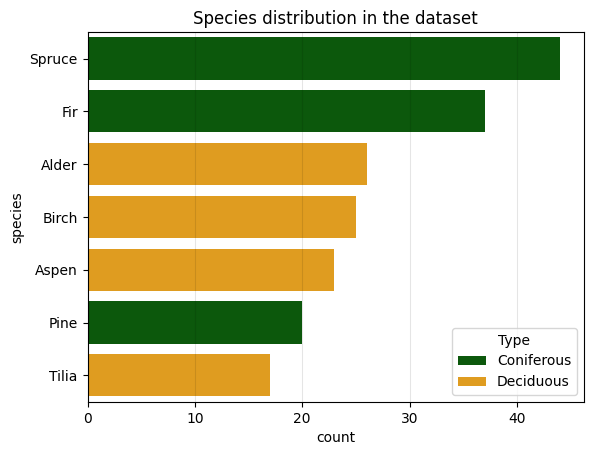

In [3]:
#| label: fig-species-count
#| fig-cap: "Distribution of tree species in the dataset. It contains 192 point clouds of individual trees: 101 coniferous and 91 deciduous."

conifers = {"Spruce", "Fir", "Pine"}
counts = data.value_counts("species").reset_index()
counts["Type"] = counts["species"].map(
    lambda x: "Coniferous" if x in conifers else "Deciduous"
)

ax = sns.barplot(
    data=counts,
    y="species",
    x="count",
    hue="Type",
    palette=["#006400", "#FFA500"],
    dodge=False,
    orient="h",
)

ax.set_title("Species distribution in the dataset")
ax.grid(axis="x", color="black", alpha=0.1)

The first experiment we report in this manuscript aims to build intuition into commonly
used features for classical machine learning on point clouds.
We set up the experiment as a classification problem with two settings: a binary one, in
which the target is the type of tree, coniferous or deciduous, and a multiclass one, in
which the target is the species directly.
The features we use include point height distribution features from
[@woodsPredictingForestStand2008] and shape features from
[@lucasIdentificationLinearVegetation2019] derived from the eigenvalues of the
covariance matrix of the coordinates.
We calculate each feature for the entire point cloud and use a 2% threshold for height
to remove ground points from the calculation, since we find they serve only as noise.
To verify that the features are meaningful and assess which are more important, we then
fit a logistic regression model on standardized feature values and look at its 10-fold
stratified cross-validation accuracy scores and feature coefficients.
Finally, we arrange each individual tree within its species group by the value of a
feature of interest and plot multiple samples from each end of the
feature range.
This allows us to associate features and their possible values with the
actual shapes of trees.

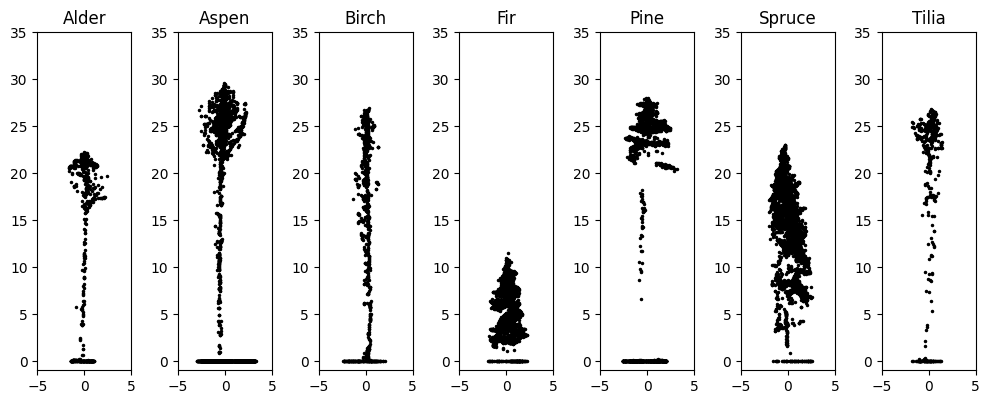

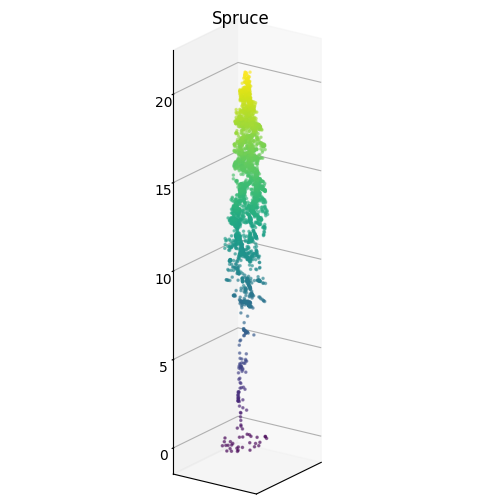

In [4]:
#| label: fig-visualization
#| layout: [[2.5, 1]]
#| fig-cap: "Visualizations of the individual tree point clouds in the dataset. Most of the tree clouds are top-heavy because of the observation from above, and some are artificially tilted because of slight terrain slopes and height normalization. The ground points are present."
#| fig-subcap:
#|  - "Cross-sections of random trees of every species (ignoring the Y dimension)."
#|  - "A spruce in 3D."

rng = np.random.default_rng(seed=1917)

unique_species = data["species"].unique()

fig, axes = plt.subplots(1, len(unique_species), figsize=(10, 7), tight_layout=True)

for ax, species in zip(axes, unique_species):
    sample = (
        data[data["species"] == species]
        .sample(n=1, random_state=rng)
        .reset_index(drop=True)
    )
    las = laspy.read(sample.loc[0, "path"])
    X, Y, Z = np.rollaxis(las.xyz, axis=1)  # (N, dim) -> (dim, N)
    ax.plot(X - X.mean(), Z, marker=".", linestyle="", markersize=3, color="k")
    ax.set_aspect("equal")
    ax.set_title(sample.loc[0, "species"])
    ax.set_ylim(-1, 35)
    ax.set_xlim(-5, 5)


fig = plt.figure(figsize=(10, 6))

spruce = data.query("species == 'Spruce'")
sample = spruce.sample(n=1, random_state=65).reset_index(drop=True)
las = laspy.read(sample.loc[0, "path"])
X, Y, Z = np.rollaxis(las.xyz, axis=1)

ax = fig.add_subplot(projection="3d")
ax.scatter(
    X - X.mean(), Y - Y.mean(), Z, s=10, c=Z, marker=".", alpha=0.5, cmap="viridis"
)
ax.set_proj_type("ortho")
ax.set_aspect("equal")
ax.view_init(elev=20, azim=35, roll=0)
ax.set_title(sample.loc[0, "species"])
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-1, 22)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

The second experiment is also set up as a multiclass classification problem.
Instead of encoding the shape of the point cloud through features based on distributions
of heights and eigenvalues of the covariance matrix, we treat the whole tree cloud as a
three-dimensional distribution.
First, we construct super-trees for each species by merging multiple scaled and centered
point clouds into one.
Figure  @fig-super-trees} shows examples of such super-trees for birch and fir,
visualized as a scatter plot with very low alpha and as a hex 2D histogram.
Then, each super-tree is used to fit a kernel density estimator by treating each point
as a three-dimensional observation.
They can then be used to estimate the likelihood of individual trees belonging to the
same distribution as each of the super-trees.

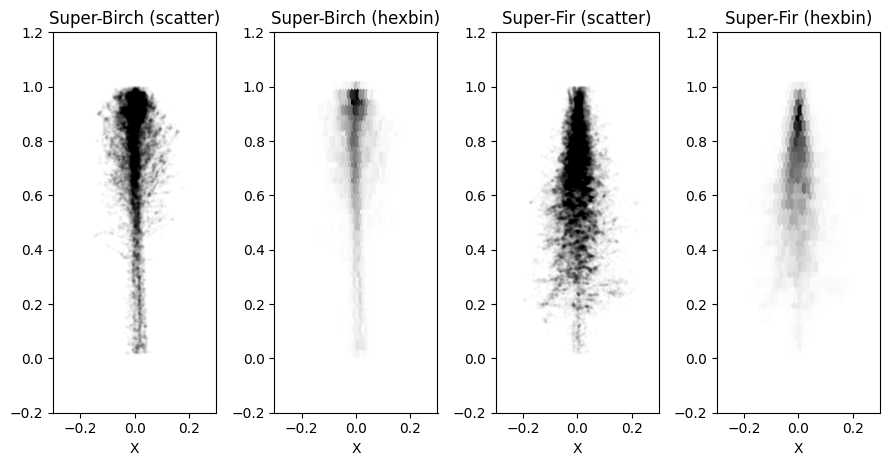

In [5]:
#| label: fig-super-trees
#| fig-cap: "Super-trees for birch and fir as a scatter plot with very low alpha and as a hex 2D histogram. A super-tree for a species is a collection of tree clouds of that species centered, scaled, and merged into one."


def get_super_tree(species: str) -> np.ndarray:
    """Construct a super-tree for the specified species."""

    clouds = [laspy.read(p).xyz for p in data.query(f"species == '{species}'")["path"]]

    assert len(clouds) > 0, "No trees found. Is the species name correct?"

    # Center and scale
    for xyz in clouds:
        means = xyz.mean(axis=0, keepdims=True)
        means[0][-1] = 0  # Don't recenter Z
        xyz -= means
        xyz /= xyz[:, 2].max()

    return np.vstack(clouds)


fig, axes = plt.subplots(1, 4, figsize=(9, 5), tight_layout=True)

for i, species in enumerate(["Birch", "Fir"]):
    super_tree = get_super_tree(species)
    X, Y, Z = np.rollaxis(super_tree, axis=1)

    height_mask = Z > 0.02
    X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]

    ax = axes[i * 2]
    ax.plot(X, Z, marker=".", linestyle="", markersize=3, color="k", alpha=0.01)
    ax.set_xlabel("X")

    ax.set_aspect("equal")
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(-0.3, 0.3)

    ax.set_title(f"Super-{species} (scatter)")

for i, species in enumerate(["Birch", "Fir"]):
    super_tree = get_super_tree(species)
    X, Y, Z = np.rollaxis(super_tree, axis=1)

    height_mask = Z > 0.02
    X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]

    ax = axes[i * 2 + 1]
    ax.hexbin(X, Z, cmap="binary", gridsize=30)
    ax.set_xlabel("X")

    ax.set_aspect("equal")
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(-0.3, 0.3)

    ax.set_title(f"Super-{species} (hexbin)")

fig.savefig(f"super-trees.png", dpi=300)

We make the data and code used in this study available through Kaggle
[@dubrovinIndividualTreesUAV2023]. The notebooks there contain additional visualizations
and experiments and are easy to copy, run, and modify in pinned environments without
installing anything locally. We only report two experiments here due to limitations on
the length of the manuscript.

# Results and discussion

An obvious limitation of this study is the size of the dataset.
A sample of 192 examples is hardly enough to run reliable experiments without investing
significant effort to avoid overfitting.
It also severely limits how tight the error bars on quantitative estimates can be.
With that limitation in mind, below we present the results of the reported experiments
and invite the reader to visit the Kaggle page that hosts the dataset to look at more
detailed results and visualizations.

Table @tbl-accuracy-1 reports the 10-fold stratified cross-validation accuracies of
the logistic regression in both settings of the first experiment.
In both settings, the model performs reasonably well, and the results are predictably
much better in the simpler binary setting.
The absolute values of the fitted coefficients, which we use to estimate the importance
of features, are dominated by features based on the height distribution of points.
Features based on the eigenvalues of the covariance matrix have very little effect on
the overall prediction because all the point clouds in the dataset are very similar in
shape.
The heights of the trees are almost an order of magnitude larger than their widths,
making one of the eigenvalues significantly larger than the rest and making all features
based on them have very similar values.
A notable exception is the omnivariance, calculated as the cube root of the product of
all three eigenvalues and consistently ending up at the top of the coefficient
magnitudes.
Figure @fig-feature-ranges presents visualizations that are the target of the first
experiment, using spruce and aspen and omnivariance and percent of points higher than
mean height as examples.
Based on the visualization, we can see how larger values of omnivariance correspond to
spruce tree clouds that are more evenly spread out in all directions, being more
elliptical than linear, and how lower values of percent of points higher than mean
height correspond to bushier, top-heavy aspen tree clouds.

In [6]:
#| label: compute-features


def compute_cloud_features(path: str, *, height_threshold: float = 1.0) -> dict:
    las = laspy.read(path)
    out = {}

    X, Y, Z = np.rollaxis(las.xyz, axis=1)

    height_mask = Z > height_threshold
    X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]

    # Height distribution features (Woods et al., 2008)
    out.update(
        {
            "z_max": Z.max(),
            "z_mean": Z.mean(),
            "z_std": Z.std(),
            "z_skew": scipy.stats.skew(Z),
            "z_kurt": scipy.stats.kurtosis(Z),
            "z_entropy": scipy.stats.entropy(Z),
            "pct_z_above_mean": np.mean(Z > Z.mean()),
            "pct_z_above_2": np.mean(Z > 2),
        }
    )

    for i, z in enumerate(np.percentile(Z, range(10, 100, 10)), 1):
        out.update({f"z_decile_{i}": z})

    counts, bins = np.histogram(Z, bins=np.linspace(Z.min(), Z.max(), 11))
    counts = np.cumsum(counts / Z.size)[:-1]
    for i, c in enumerate(counts, 1):
        out.update({f"z_cumrat_{i}": c})

    # Eigenvalue features (Lucas et al., 2019)
    covariance_matrix = np.cov(las.xyz, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    lambda1, lambda2, lambda3 = sorted(eigenvalues, reverse=True)

    out.update(
        {
            "linearity": (lambda1 - lambda2) / lambda1,
            "planarity": (lambda2 - lambda3) / lambda1,
            "scatter": lambda3 / lambda1,
            "omnivariance": np.cbrt(lambda1 * lambda2 * lambda3),
            "eigentropy": -lambda1 * np.log(lambda1)
            - lambda2 * np.log(lambda2)
            - lambda3 * np.log(lambda3),
            "sum_of_eigenvalues": lambda1 + lambda2 + lambda3,
            "curvature": lambda3 / (lambda1 + lambda2 + lambda3),
        }
    )

    return out


features = pd.json_normalize(data["path"].map(compute_cloud_features))
full = pd.concat([data, features], axis=1)

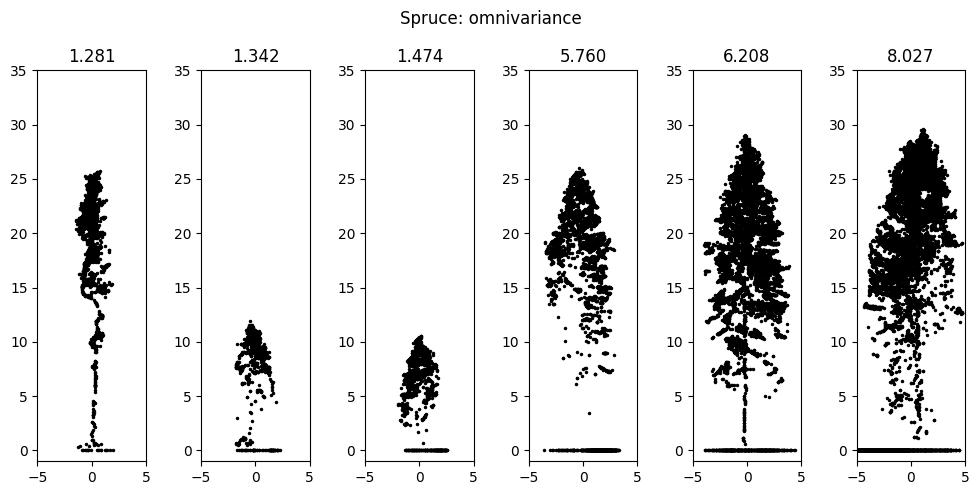

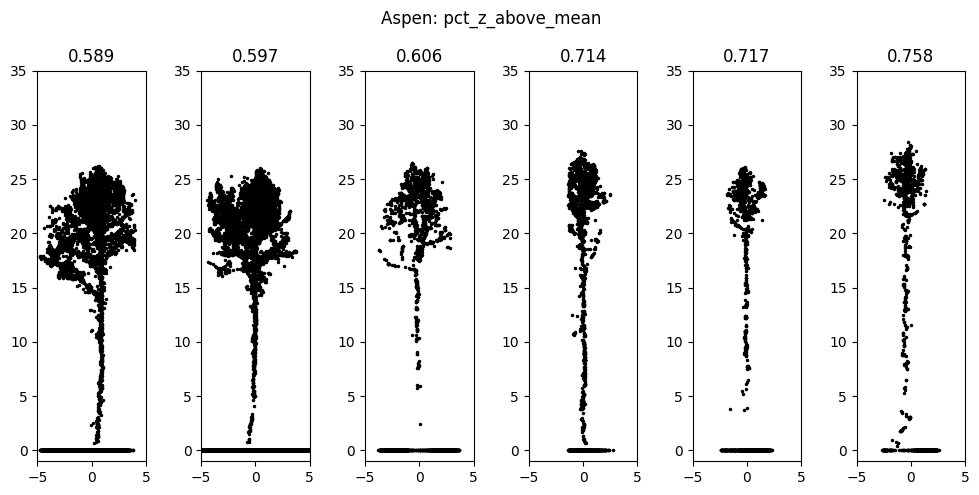

In [7]:
#| label: fig-feature-ranges
#| layout-nrow: 2
#| fig-cap: "Example visualizations of the shapes of individual trees on different ends of ranges of commonly used features in classical machine learning on point clouds."
#| fig-subcap:
#|  - "Effect of omnivariance on the shape of spruce."
#|  - "Effect of percent of points higher than mean height on the shape of aspen."


def visualize_feature_range(species: str, feature: str) -> None:
    subset = full.query(f"species == '{species}'").sort_values(feature)
    extremes = subset.iloc[[0, 1, 2, -3, -2, -1], :].loc[:, ["path", feature]]
    fig, axes = plt.subplots(1, 6, figsize=(10, 5), tight_layout=True)

    for (i, row), ax in zip(extremes.iterrows(), axes):
        las = laspy.read(row["path"])
        X, Y, Z = np.rollaxis(las.xyz, axis=1)
        ax.plot(X - X.mean(), Z, marker=".", linestyle="", markersize=3, color="k")
        ax.set_aspect("equal")
        ax.set_title(f"{row[feature]:.3f}")
        ax.set_ylim(-1, 35)
        ax.set_xlim(-5, 5)

    fig.suptitle(f"{species}: {feature}")


visualize_feature_range("Spruce", "omnivariance")
visualize_feature_range("Aspen", "pct_z_above_mean")

In [8]:
#| label: fit-linear-regressions

conifers = {"Spruce", "Fir", "Pine"}
full["type"] = data["species"].map(
    lambda x: "Coniferous" if x in conifers else "Deciduous"
)

X = full.drop(columns="path").copy()
y_binary = X.pop("type")
y_multi = X.pop("species")

X.loc[X["z_entropy"] == float("-inf"), "z_entropy"] = -1

X_train, X_test, y_binary_train, y_binary_test, y_multi_train, y_multi_test = (
    train_test_split(
        X,
        y_binary,
        y_multi,
        test_size=0.4,
        random_state=68,
        shuffle=True,
        stratify=y_multi,
    )
)

clf_binary = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10_000,
    ),
)

cv_result_binary = cross_validate(
    estimator=clf_binary,
    X=X,
    y=y_binary,
    cv=10,
    scoring="accuracy",
)

scores = cv_result_binary["test_score"]

clf_multi = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10_000,
        multi_class="multinomial",
    ),
)

cv_result_multi = cross_validate(
    estimator=clf_multi,
    X=X,
    y=y_multi,
    cv=10,
    scoring="accuracy",
)

scores_multi = cv_result_multi["test_score"]

In [9]:
#| label: tbl-accuracy-1
#| tbl-cap: "10-fold stratified cross-validation accuracy for the logistic regression in binary and multiclass settings."

pd.DataFrame(
    data={
        "CV accuracy": [
            f"{scores.mean():.3f} ± {scores.std():.3f}",
            f"{scores_multi.mean():.3f} ± {scores.std():.3f}",
        ],
    },
    index=["Binary", "Multiclass"],
)

,CV accuracy
Binary,0.927 ± 0.042
Multiclass,0.777 ± 0.042


The metrics for the second experiment were calculated on a 40% hold-out set obtained
from the entire dataset by stratified sampling and are shown in table
@tbl-accuracy-2.
The confusion matrices for both settings are shown in Figure @fig-confusion.
Once again, the results in the binary setting are significantly better than in the
multiclass one, which is to be expected, especially with such a small overall sample
size and a relatively large number of classes.
Per-species metrics are all over the place: out of the 8 pines in the hold-out set,
every one was classified correctly, and at the same time, not a single one of the 7
tilia was.
Despite the overall performance in the multiclass setting being very low and chaotic,
it's still significantly better than random, which leads us to believe that the quality
can be improved on larger samples.
It is, however, important to note that the approach of estimating 3D kernel density for
each species takes too long during the inference phase, despite being relatively easy to
set up and apply and showing reasonable quality in the binary setting.

In [10]:
#| label: construct-super-trees

mega_trees = {}
sample_sizes = {}

for species in unique_species:
    subset = data.query(f"species == '{species}'").join(X_train, how="inner")
    train_point_clouds = [laspy.read(path).xyz for path in subset["path"]]

    for xyz in train_point_clouds:
        means = xyz.mean(axis=0, keepdims=True)
        means[0][-1] = 0  # Don't recenter Z
        xyz -= means
        xyz /= xyz[:, 2].max()

    mega = np.vstack(train_point_clouds)
    mega_trees[species] = mega[mega[:, 2] > 0.02]
    sample_sizes[species] = len(train_point_clouds)
    X, Y, Z = np.rollaxis(mega, axis=1)

    height_mask = Z > 0.03
    X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]

In [11]:
#| label: estimate-densities

kds = {}

for species in unique_species:
    tree = mega_trees[species]

    kd = KernelDensity(
        bandwidth=0.05,
        kernel="gaussian",
    )
    kd.fit(tree)
    kds[species] = kd

In [12]:
#| label: score
#| include: false

out = []

for species in tqdm.tqdm(unique_species):
    subset = data.query(f"species == '{species}'").join(X_test, how="inner")
    for i, row in subset.iterrows():
        xyz = laspy.read(row["path"]).xyz

        means = xyz.mean(axis=0, keepdims=True)
        means[0][-1] = 0  # Don't recenter Z
        xyz -= means
        xyz /= xyz[:, 2].max()
        xyz = xyz[xyz[:, 2] > 0.02]

        for kd_species, kd in kds.items():
            out.append(
                {
                    "original_index": i,
                    "gt": species,
                    f"scoring_dist": kd_species,
                    "score": kd.score(xyz[::10]) / xyz.shape[0],
                }
            )

out = pd.json_normalize(out)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:10<00:00, 18.63s/it]


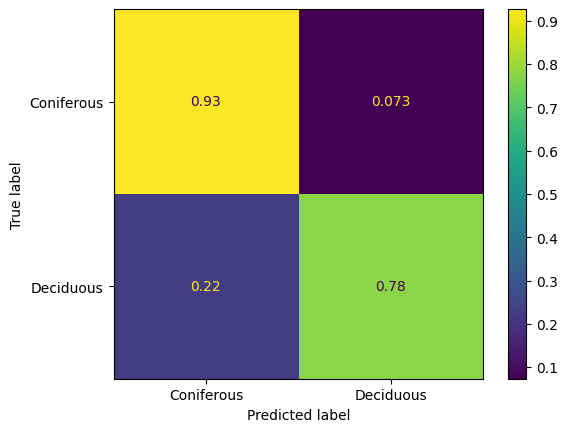

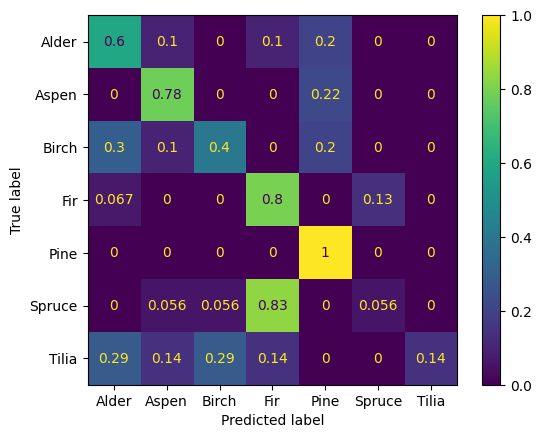

In [13]:
#| label: fig-confusion
#| layout-ncol: 2
#| fig-cap: "Confusion matrices for prediction of tree species by calculating the log-likelihood of its tree cloud points being from the distribution estimated on the corresponding super-tree."
#| fig-subcap:
#|  - "Binary setting: predicting conifers vs. deciduous trees"
#|  - "Multiclass setting: predicting the species directly."

results = out.sort_values("score").groupby("original_index").last()
results["correct"] = results["gt"] == results["scoring_dist"]
results["type"] = results["gt"].map(
    lambda x: "Coniferous" if x in conifers else "Deciduous"
)
results["pred_type"] = results["scoring_dist"].map(
    lambda x: "Coniferous" if x in conifers else "Deciduous"
)
results["binary_correct"] = results["type"] == results["pred_type"]

cm_b = ConfusionMatrixDisplay.from_predictions(
    y_true=results["type"],
    y_pred=results["pred_type"],
    normalize="true",
)

cm_m = ConfusionMatrixDisplay.from_predictions(
    y_true=results["gt"],
    y_pred=results["scoring_dist"],
    normalize="true",
)

In [14]:
#| label: tbl-accuracy-2
#| tbl-cap: "Hold-out set accuracy for the second experiment. The hold-out set is a 40% stratified sample from the entire dataset."

pd.DataFrame(
    data={
        "Accuracy": [
            f"{results['binary_correct'].mean():.3f}",
            f"{results.groupby('type')['binary_correct'].mean()['Coniferous']:.3f}",
            f"{results.groupby('type')['binary_correct'].mean()['Deciduous']:.3f}",
            f"{results['correct'].mean():.3f}",
            f"{results.groupby('type')['correct'].mean()['Coniferous']:.3f}",
            f"{results.groupby('type')['correct'].mean()['Deciduous']:.3f}",
        ],
    },
    index=[
        "Binary: Overall", 
        "Binary: Coniferous",
        "Binary: Deciduous",
        "Multiclass: Overall", 
        "Multiclass: Coniferous",
        "Multiclass: Deciduous",
    ],
)

,Accuracy
Binary: Overall,0.857
Binary: Coniferous,0.927
Binary: Deciduous,0.778
Multiclass: Overall,0.506
Multiclass: Coniferous,0.512
Multiclass: Deciduous,0.500


# Conclusions

This manuscript offers an overview of a study aimed at exploring the properties of point
clouds of individual trees and searching for insight into the complex open problem of
individual tree detection in large point clouds.
We report two experiments, the first of which is set up to explore how commonly used
features in classical machine learning on point clouds manifest in the shapes of actual
individual trees, and the second -- to test the validity of approximating the shapes of
trees by fitting a kernel density estimator on super-trees of different species.
We show an example of how arranging visualizations of tree clouds based on the value of
a feature can be used to gain intuition on what that feature represents in the real
world.
We also show how a super-tree can be used to estimate a kernel density function and how
that function can be used to predict whether a tree cloud belongs to a specific species.
This ends up being relatively straightforward to set up but results in very slow
inference and subpar quality, at least at this sample size.
Both of the approaches described can be adapted to segmentation and detection in large
point clouds by applying the classification algorithms in windows.

# Acknowledgements

All data was collected and processed by Space technologies and services center, Ltd,
Perm, Russia and published with their permission.